# Time to get your hands dirty. Your first neural network; pick your favourite.
For the last coding assignment, you'll need to implement a neural network. We'll look at a relatively simple binary classification problem. Here below are three options; completing one of them for the exam is enough
## Tasks:
- Remember: scale your data appropriately

- Decide on a testing strategy (a simple test/train split? a CV strategy? set a test set aside to be looked at at the very end?)

- Decide your optimization metric.

- Write down your network architecture. You can start from a fully connected, multi-layer perceptron (and then explore)

- Use one the package among those we've seen. These include Tensorflow via keras, pytorch, and the MPL classifier implemented in scikit-learn. This is an opportunity to pick the one you're most interested in learning.

- Optimize the hyperparameters of your network. Explore different hyperparameters and see what fits the data best. Do your best now to optimize the network architecture. Be creative!

- Report on the perfomance of the network on the test set; report other metrics that have not been optimized.

## A few tips:
- In scikit-learn, remember that you can utilize all availables cores on your machine with n_jobs=-1.
Print out the classification score for the training data, and the best parameters obtained by the cross validation.
- If it takes too long, run the hyperparameter optimization on a subset of the training set. Then retrain the full network using the best hyperparameters only.
- On cross validation, for scikit learn we've seen how to use GridSearchCV already. For Tensorflow, there's a really cool tool called Tensorboard

## Datasets:
You can choose one of these three problems:

1. Galaxies vs quasars (but with neural networks) Go back to our SDSS data we've used in Lecture 19. We had color differences, and the task was to classifty quasars vs galaxies. Repeat that task with a neural network.

2. Can a computer learn if we're going to detect gravitational waves? (but with neural networks) Go back to the SNR classifier for gravitational wave events, same data we've used in Lecture. We had properties of black hole binaries, and the task was to classify. Repeat that task with a neural network.

3. The HiggsML challenge Branching out of astrophysics, let's mess around with a dataset of simulated but realistic events from the ATLAS particle detector at CERN.

- Data are at solutions/higgs.tar.gz (you need to uncompress with tar -czvf)
- There are $N_{samples}=2.5x10^5$ entries with $N_{features}=30$ features each.
- The taks is that of classifying these features against a set of labels, which are either s (source) or b (background).
- For some info on both the physics and the dataset see this document; includes a description of the features and how data have been padded (-999) for missing values.
- This dataset was part of a challenge that run on Kaggle in 2014: https://higgsml.ijclab.in2p3.fr/


In [22]:
import numpy as np
import pylab as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score
import joblib
import seaborn as sns
from sklearn.neural_network import MLPClassifier

In [3]:
df = pd.read_csv('/home/sara/higgs.csv')
df

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.002653,s
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,2.233584,b
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,2.347389,b
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,5.446378,b
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,6.245333,b
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,349995,-999.000,71.989,36.548,5.042,-999.00,-999.000,-999.000,1.392,5.042,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,4.505083,b
249996,349996,-999.000,58.179,68.083,22.439,-999.00,-999.000,-999.000,2.585,22.439,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,2.497259,b
249997,349997,105.457,60.526,75.839,39.757,-999.00,-999.000,-999.000,2.390,22.183,...,1,41.992,1.800,-0.166,-999.000,-999.00,-999.000,41.992,0.018636,s
249998,349998,94.951,19.362,68.812,13.504,-999.00,-999.000,-999.000,3.365,13.504,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,1.681611,b


In [4]:
# Drop the ID column (not useful for training)
data = df.drop(columns=['EventId'])
# Replace labels: 's' -> 1, 'b' -> 0
data['Label'] = data['Label'].replace({'s': 1, 'b': 0})

/tmp/ipykernel_1075/3467513320.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Label'] = data['Label'].replace({'s': 1, 'b': 0})


In [5]:
# Drop all rows that contain any -999 value
data = data[~(data == -999).any(axis=1)] 
# Note: This removes approximately 73% of the dataset, leaving only about 27% of the original samples.

In [6]:
data

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,138.470,51.655,97.827,27.980,0.910,124.711,2.666,3.064,41.928,197.760,...,2,67.435,2.150,0.444,46.062,1.240,-2.475,113.497,0.002653,1
5,89.744,13.550,59.149,116.344,2.636,284.584,-0.540,1.362,61.619,278.876,...,3,90.547,-2.412,-0.653,56.165,0.224,3.106,193.660,0.083414,0
6,148.754,28.862,107.782,106.130,0.733,158.359,0.113,2.941,2.545,305.967,...,2,123.010,0.864,1.450,56.867,0.131,-2.767,179.877,0.002653,1
11,114.744,10.286,75.712,30.816,2.563,252.599,-1.401,2.888,36.745,239.804,...,3,76.773,-0.790,0.303,56.876,1.773,-2.079,165.640,0.307170,0
23,141.481,0.736,111.581,174.075,1.955,364.344,-0.923,1.335,6.663,440.859,...,2,195.533,1.156,1.416,82.477,-0.798,-2.785,278.009,0.001503,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249976,137.371,4.640,92.603,107.121,3.189,322.430,-2.384,2.149,2.755,225.261,...,2,85.132,1.991,-1.518,51.068,-1.197,-2.831,136.200,0.001503,1
249980,119.934,20.078,88.751,35.227,0.660,111.491,1.836,2.800,18.532,189.198,...,2,69.219,-1.064,1.118,43.719,-1.725,-2.756,112.938,0.018636,1
249985,126.151,29.023,95.258,152.684,1.000,163.066,-0.240,1.504,24.642,327.502,...,2,158.904,0.401,0.034,34.196,-0.599,-2.525,193.099,0.018636,1
249993,130.075,3.918,66.781,77.369,0.936,322.296,-0.207,3.102,49.937,610.482,...,3,155.864,-0.358,1.093,134.344,0.578,-2.215,546.066,0.001503,1


In [18]:
# Split features (X) and target (y)
X = data.drop(columns=['Label']) 
y = data['Label'] 

In [8]:
#train/test split (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,        
    stratify=y,             # Preserve the proportion of class labels
    random_state=42        
)
y_train = y_train.values
y_test = y_test.values

In [9]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Define the hyperparameter grid to search over
param_grid = {
    'hidden_layer_sizes': [
        (32, 16), # input(30) → 32 → 16 → output(1)
        (64, 32), # input(30) → 64 → 32 → output(1)
        (16, 8), # input(30) → 16 → 8 → output(1)
        (24, 12), # input(30) → 24 → 12 → output(1)
    ],
    'alpha': [0.00001, 0.0001, 0.001, 0.01], # L2 regularization parameter to reduce overfitting
    'learning_rate_init': [0.0001,0.005, 0.001, 0.01], #Learning rate 
    'activation': ['relu', 'tanh'] # Activation functions
}

# Fixed model parameters that won't change during the grid search
fixed_params = {
    'solver': 'adam',  # Optimization algorithm
    'max_iter': 150,  # Maximum number of training iterations
    'early_stopping': True,  # Stop early if validation score does not improve
    'random_state': 42  # Seed for reproducibility
}

mlp_base = MLPClassifier(**fixed_params) 

# Setup GridSearchCV to tune hyperparameters using 3-fold cross-validation
grid_search = GridSearchCV(
    estimator=mlp_base,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train_scaled, y_train)

best_model = grid_search.best_estimator_
#save_path = path + "best_mlp_model_activation_v2.pkl"
#joblib.dump(best_model, save_path)

In [20]:
best_model = joblib.load("best_mlp_model_activation_v2.pkl") # Load the saved MLP model
scaler = joblib.load("scaler.pkl")

# Extract key hyperparameters from the loaded model
hidden_layers = best_model.hidden_layer_sizes
alpha = best_model.alpha
learning_rate_init = best_model.learning_rate_init
activation = best_model.activation


# Print the network architecture and hyperparameters
print("Network architecture: {} → {} → {} → 1".format(
    X_train.shape[1],
    hidden_layers[0],
    hidden_layers[1]
))
print(f"L2 regularization (alpha): {alpha}")
print(f"Initial learning rate: {learning_rate_init}")
print(f"Activation function: {activation}")
print(f"Solver: adam (fixed)\n")


Network architecture: 31 → 16 → 8 → 1
L2 regularization (alpha): 1e-05
Initial learning rate: 0.005
Activation function: relu
Solver: adam (fixed)



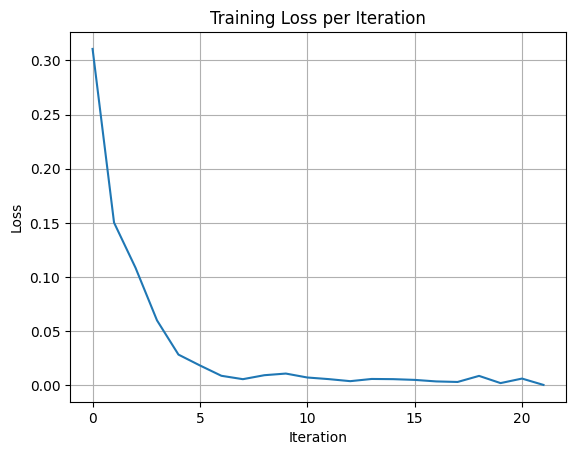

In [ ]:
# Plot the training loss curve over iterations to visualize model convergence
plt.plot(best_model.loss_curve_)
plt.title("Training Loss per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

Confusion Matrix:
 [[10864     2]
 [   11  9558]]
Accuracy: 0.9993638365549302
Completeness: 0.9989
Contamination: 0.0002


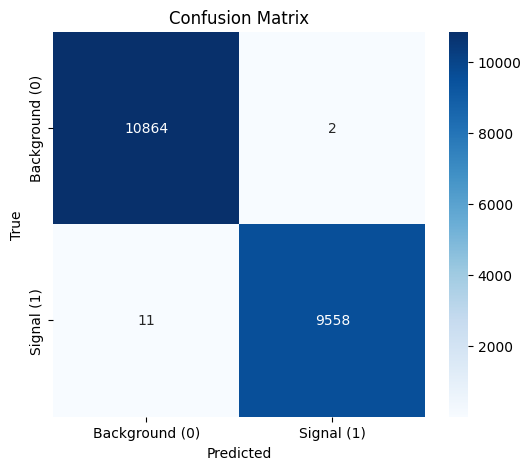

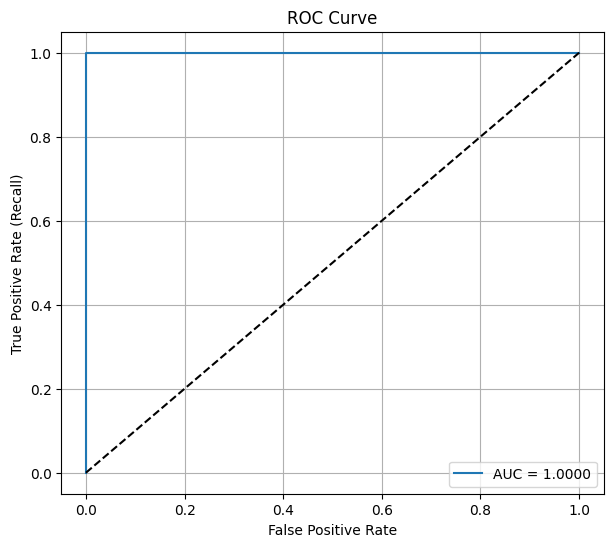

In [21]:
y_pred = best_model.predict(X_test_scaled) # Predict the classes on the scaled test set
y_prob = best_model.predict_proba(X_test_scaled)[:, 1] # Predict probabilities for the positive class (signal)

# Compute confusion matrix 
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)
print("Accuracy:", accuracy_score(y_test, y_pred))

tn, fp, fn, tp = cm.ravel()
completeness = tp / (tp + fn)
contamination = fp / (tp + fp)
print(f"Completeness: {completeness:.4f}")
print(f"Contamination: {contamination:.4f}")

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Background (0)', 'Signal (1)'], 
            yticklabels=['Background (0)', 'Signal (1)'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

#Plot Roc Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()
